In [1]:
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import pandas as pd
import matplotlib.pyplot as plt
import scvi
import torch
import scipy.sparse as sp

from rich import print
import warnings
warnings.filterwarnings("ignore")
import os

outdir = "/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_cd4_batch_annotation/PICA0001-PICA0007"
os.makedirs(outdir, exist_ok=True)
sc.settings.figdir = "/Users/jessica/Documents/GitHub/Jessica_notebooks/figures/PICA0001-PICA0007/02_annotation_cd4"


/Users/jessica/mambaforge/envs/scanpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Visualize the current cd4 annotation progress
cd4 = sc.read_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation//PICA0001-PICA0007/PICA0001-PICA0007_cd4_annotations.h5ad")
print(cd4)

AnnData object with n_obs × n_vars = 10059 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset', 'leiden_res_0.5', 
'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 
'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 
'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 
'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 
'log1p_total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 
'highly_variable_intersection'
    uns: 'cell_type_colors', 'hvg', 'leiden_res_0.5', 'leiden_res_0.5_colors', 'leiden_res_1.0', 
'leiden_res_1.0_colors', 'leiden_res_1.5', 'leiden_res_1.5_colors', 'leiden_res_2.0', 'leiden_res_2.0_colors', 
'log1p', 'neighbors', 'pca', 'pica_id_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
cd4.obs['cell_type'].unique()
cd4.obs['cell_type'].value_counts()

cell_type
Naive/Central memory CD4 T cell    9527
Regulatory T cell                   267
CCR6+ memory CD4 T cell             222
Cytotoxic CD4 T cell                 43
Name: count, dtype: int64

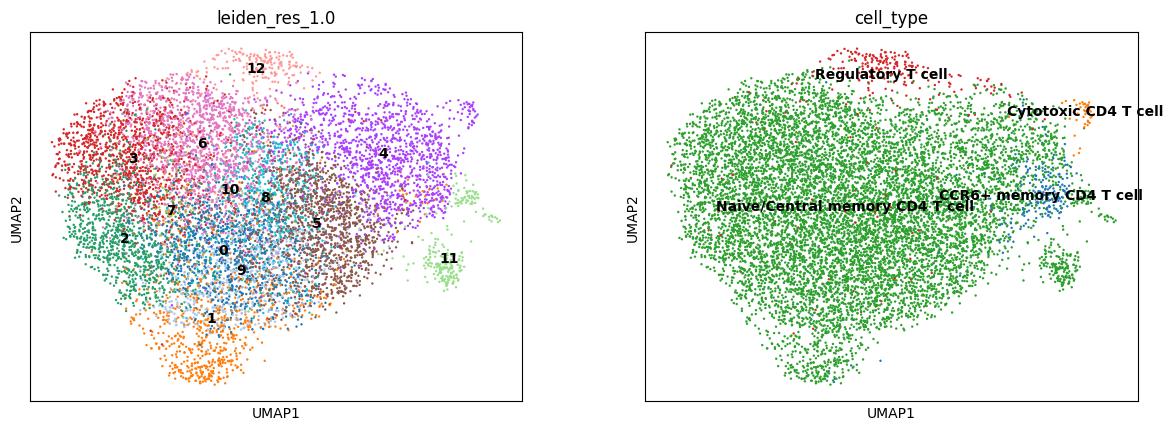

In [6]:
sc.pl.umap(cd4, color=['leiden_res_1.0', 'cell_type'], legend_loc='on data', legend_fontsize= 10)

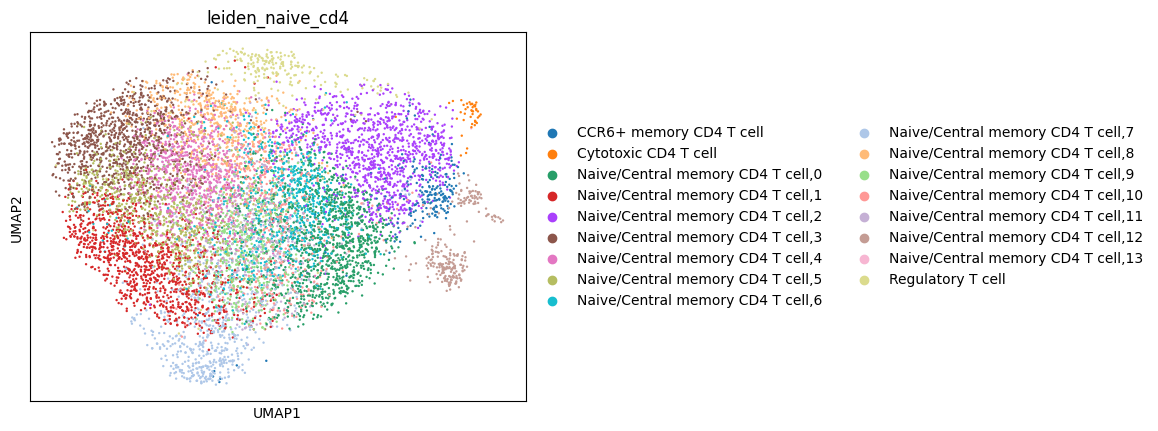

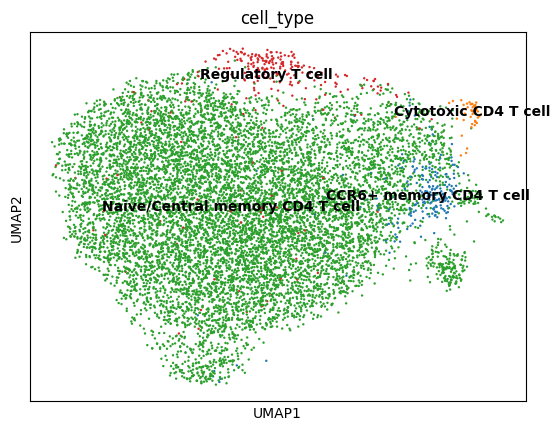

In [7]:
naive_memory_cd4 = cd4.copy()
sc.tl.leiden(naive_memory_cd4, resolution=1.0, restrict_to=('cell_type', ['Naive/Central memory CD4 T cell']), key_added='leiden_naive_cd4')
sc.pl.umap(naive_memory_cd4, color=['leiden_naive_cd4'], legend_loc='right margin')
sc.pl.umap(naive_memory_cd4, color=['cell_type'], legend_loc='on data')

In [8]:
cd4_markers = {
    # Identity
    "CD4 T cell": ["CD4", "CD3D", "CD3E"],

    # Core
    "Naive CD4 T cell": ["CCR7", "TCF7", "LEF1", "FOXP1", "PTPRC", "STAT6"],
    "Activated CD4 T cell": ['CCR7', 'CD40LG', 'CD69', 'ICOS', 'SELL', 'SOCS3', 'STAT3', 'TCF7', 'IL2RA', 'CD44', 'HLA-DRB1'],
    "CD4 central memory T cell": ["CCR7", "CD27", "CD28", "SELL", 'CD44', "TCF7", "IL7R", "BCL2", "PTPRC"],
    "CD4 effector memory T cell": ['CCR7', "IL7R", "AQP3", "CCR6", 'KLRB1', "DPP4",  "IFNG", "TNF", "IL2"], # CCR7-
    "T Stem cell Memory (Tscm)": ["PTPRC", "CCR7", "FAS", "IL7R", "SELL", "BCL2", "LEF1"],

    # cytotoxic and regulatory
    "Cytotoxic CD4 T cell": ["CD27", "CD28", "GZMB", "PRF1", "NKG7", "CCL3", "CCL4", "CCL5", "IFNG", "TBX21"], # CD27- CD28-
    "Regulatory T cell (Treg)": ["FOXP3", "IL2RA", "CTLA4", "TNFRSF18", "IKZF2", "ENTPD1"],

    #Tfh/ Tfr
    "Tfr":             ["FOXP3","IL2RA","CTLA4","CXCR5","BCL6","PDCD1","ICOS"],
    "Tfh/cTfh":        ["CXCR5","PDCD1","ICOS","BCL6","SH2D1A","TOX2"],

    # Polarizations
    "Th0 cell": ["CCR7", "IL7R", "CD27", "PTPRC", "STAT6"],
    "Th1 cell": ["TBX21", "IFNG", "CXCR3", "STAT1"],
    "Th2 cell": ["GATA3", "IL4", "IL5", "IL13", "STAT6", "CCR4"],
    "Th17 cell": ["RORC", "IL17A", "IL17F", "IL22", "CCR6", "STAT3"],

    "Suppressed CD4 T cell": ["LAG3", "PDCD1", "TIGIT", "HAVCR2", "TOX", "ENTPD1", "EOMES"],
}


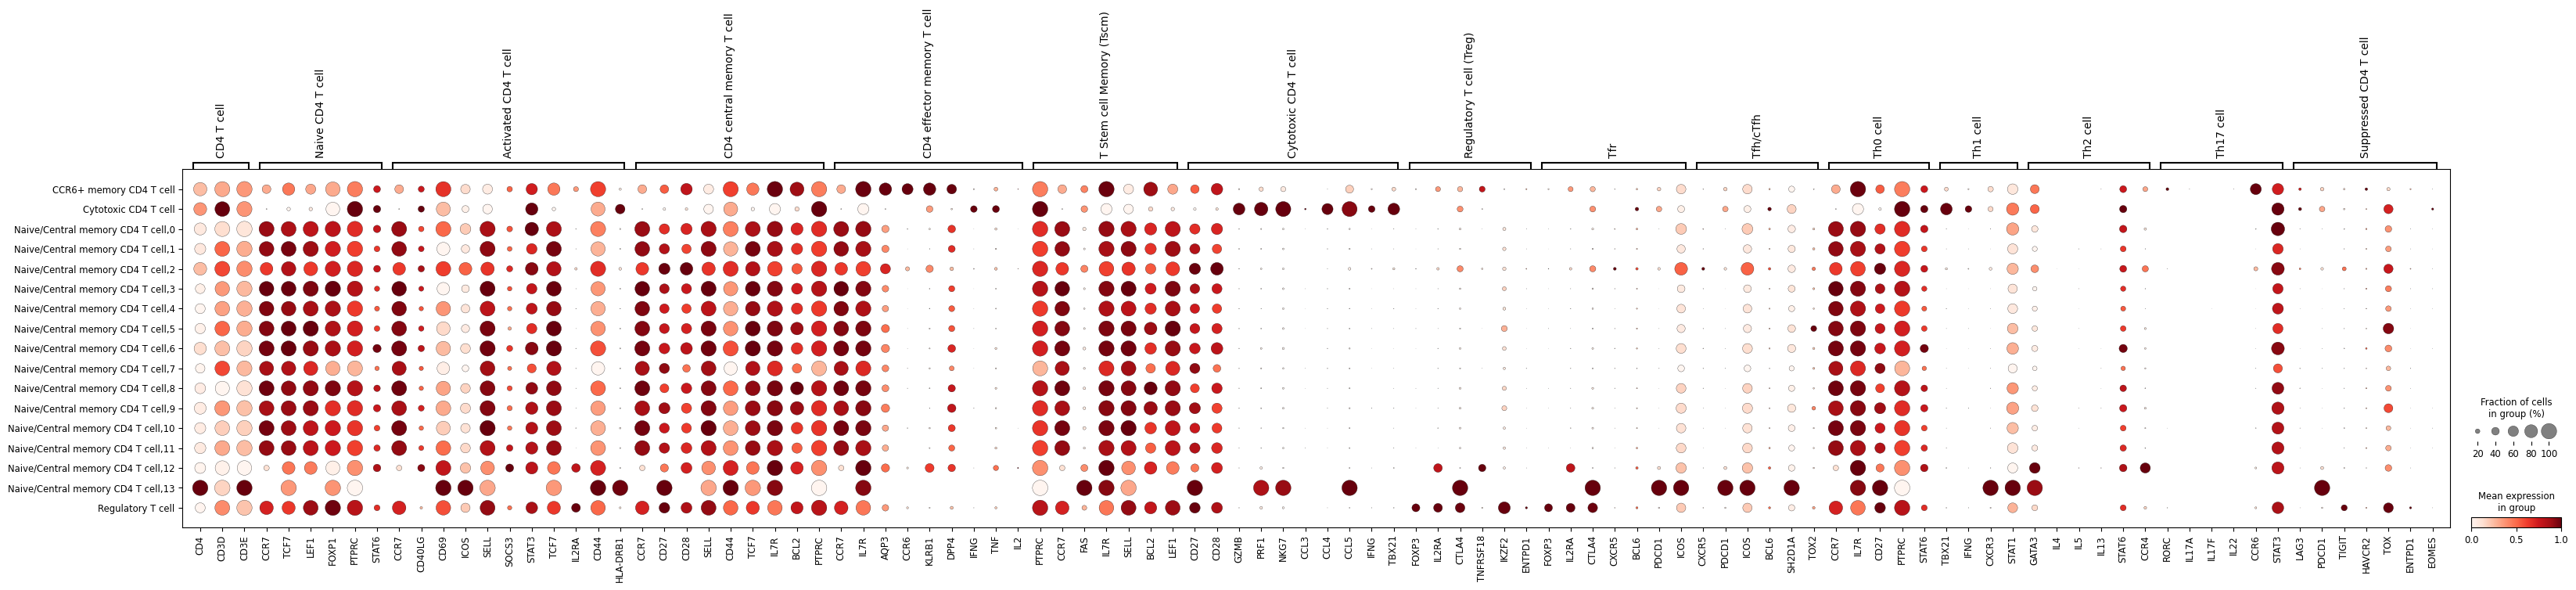

In [9]:
sc.pl.dotplot(naive_memory_cd4, cd4_markers, groupby="leiden_naive_cd4", standard_scale="var")


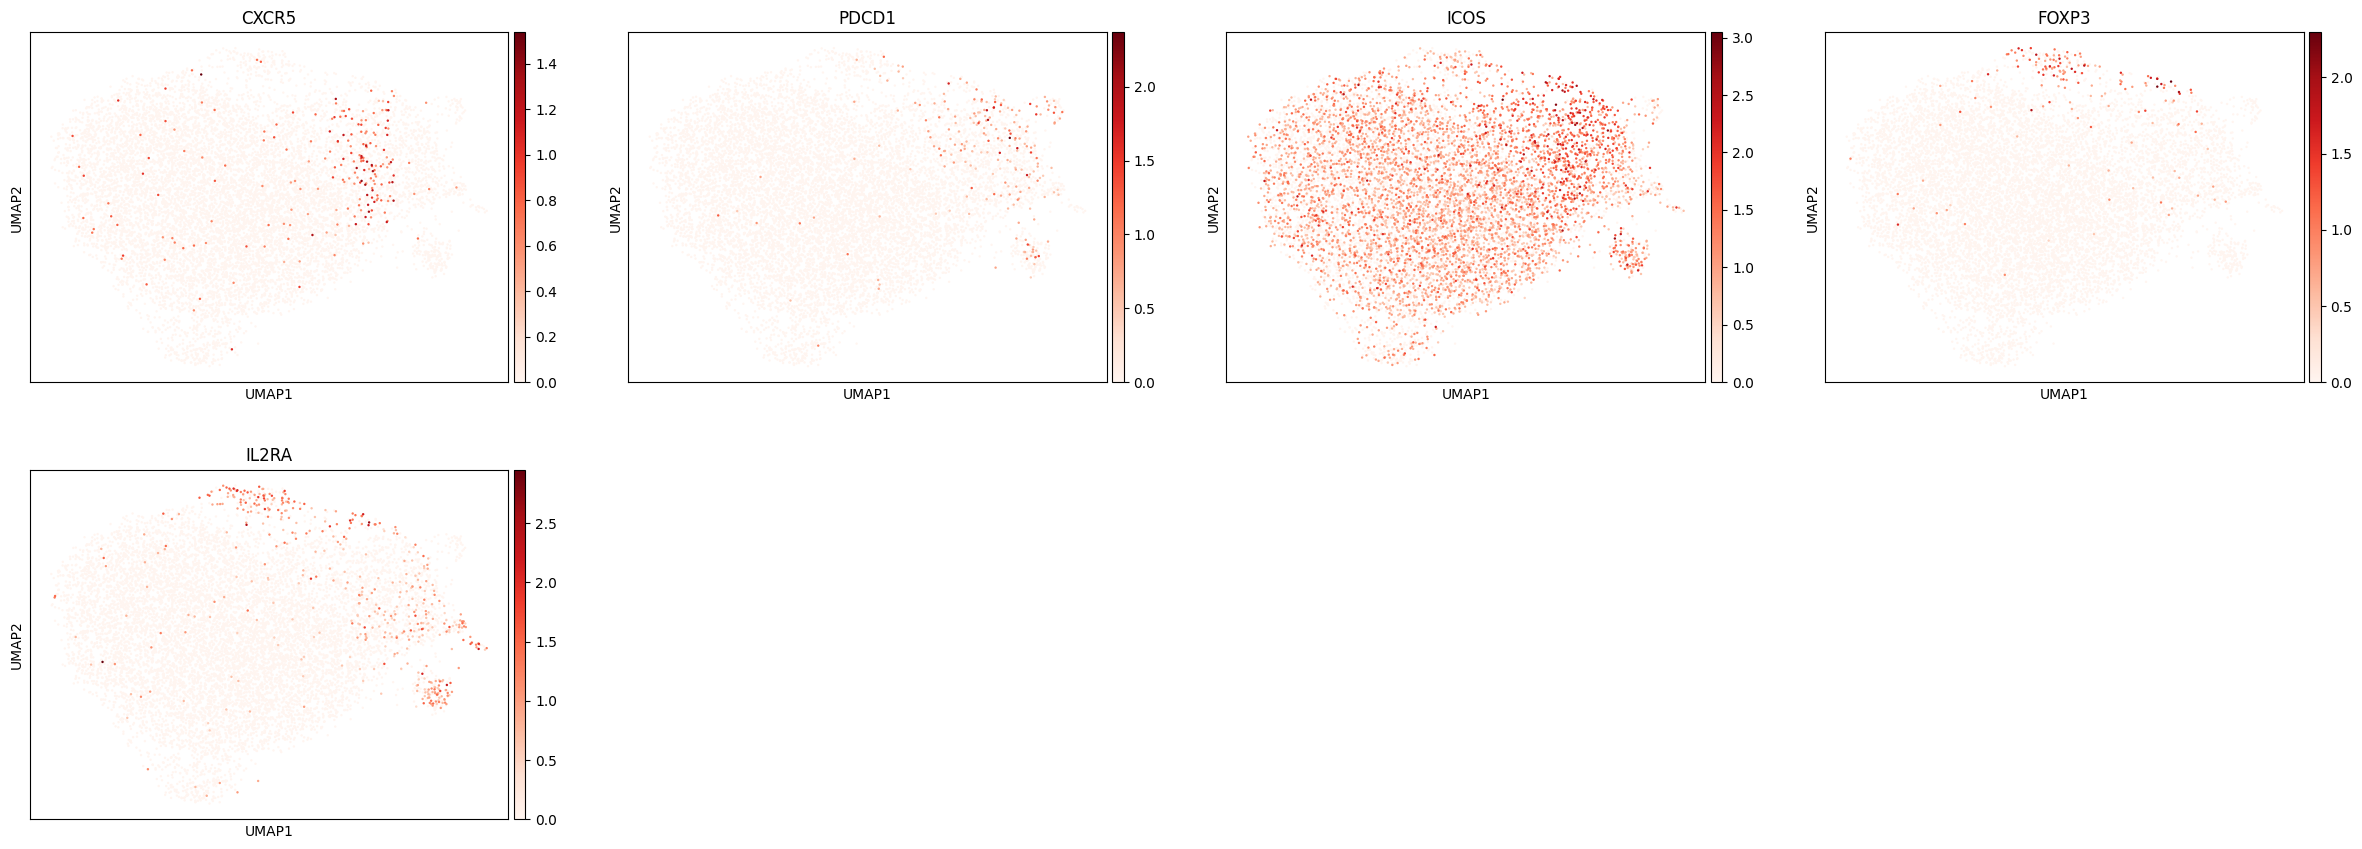

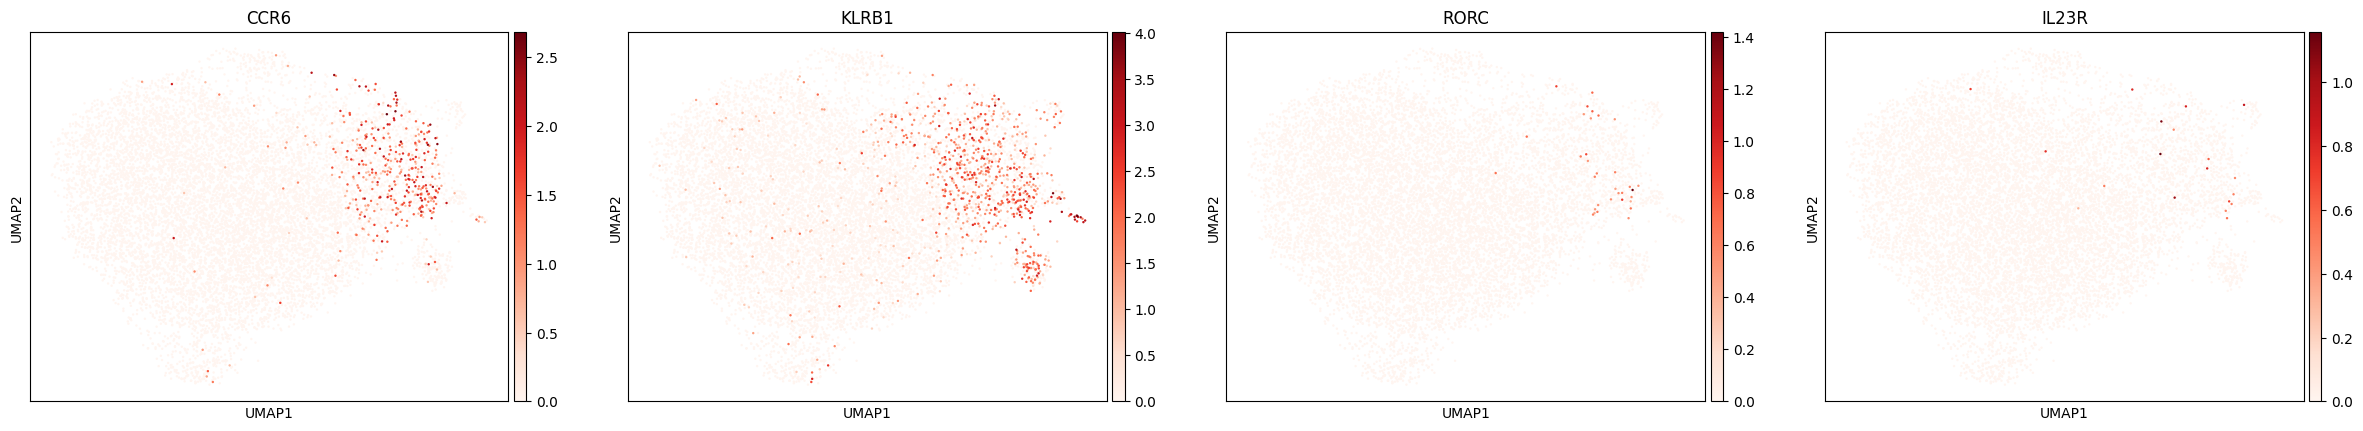

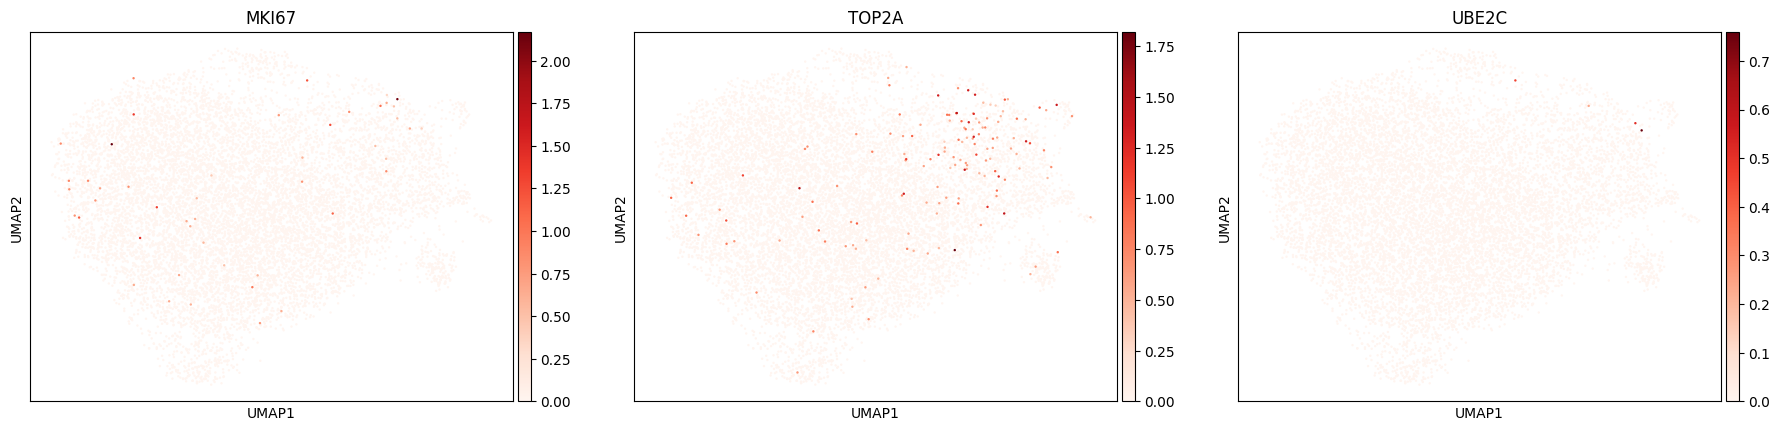

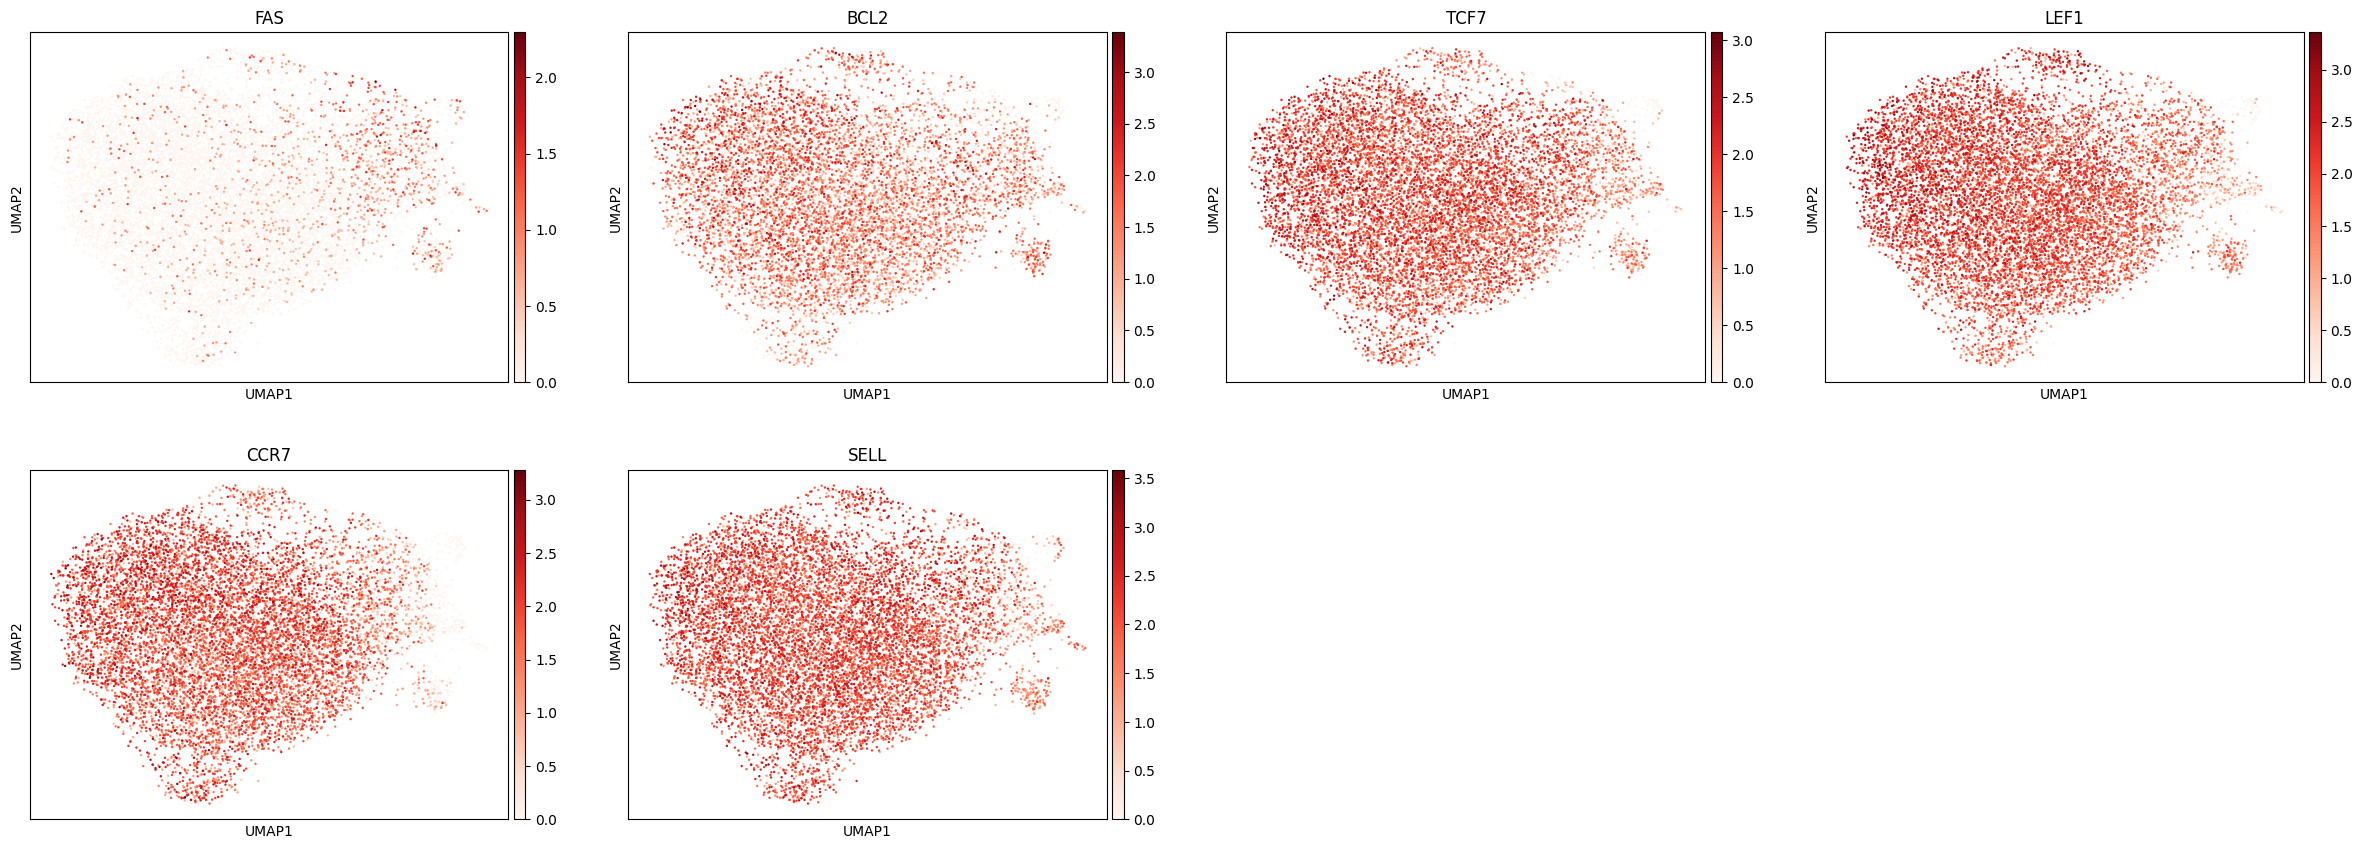

In [10]:
sc.pl.umap(naive_memory_cd4, color=["CXCR5","PDCD1","ICOS","FOXP3","IL2RA"], cmap="Reds")
sc.pl.umap(naive_memory_cd4, color=["CCR6","KLRB1","RORC","IL23R"], cmap="Reds")
sc.pl.umap(naive_memory_cd4, color=["MKI67","TOP2A","UBE2C"], cmap="Reds")
sc.pl.umap(naive_memory_cd4, color=["FAS","BCL2","TCF7","LEF1","CCR7","SELL"], cmap="Reds")

Tfh / cTfh -> CXCR5+ PDCD1+ ICOS+ \
Th17 -> CCR6+ KLRB1+ (±RORC/IL23R) \
Cycling CD4 T cell -> MKI67/TOP2A/UBE2C+ \
T stem-cell memory CD4 T cell -> naïve-like + FAS/BCL2 high

In [ ]:

naive_memory_cd4.obs['cell_type'] = naive_memory_cd4.obs['cell_type'].astype(str)
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,0', 'cell_type'] = 'Naive/Central memory CD4 T cell' 
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,1', 'cell_type'] = 'Naive/Central memory CD4 T cell'  
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,2', 'cell_type'] = 'Tfh / cTfh' 
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,3', 'cell_type'] = 'Naive/Central memory CD4 T cell'  
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,4', 'cell_type'] = 'Naive/Central memory CD4 T cell' 
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,5', 'cell_type'] = 'Naive/Central memory CD4 T cell'
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,6', 'cell_type'] = 'Naive/Central memory CD4 T cell' 
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,7', 'cell_type'] = 'Naive/Central memory CD4 T cell' 
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,8', 'cell_type'] = 'Naive/Central memory CD4 T cell' 
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,9', 'cell_type'] = 'Naive/Central memory CD4 T cell' 
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,10', 'cell_type'] = 'Naive/Central memory CD4 T cell' 
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,11', 'cell_type'] = "Th17-like memory CD4 T cell"
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,12', 'cell_type'] = "Cycling CD4 T cell"
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,13', 'cell_type'] = "T stem-cell memory CD4 T cell"

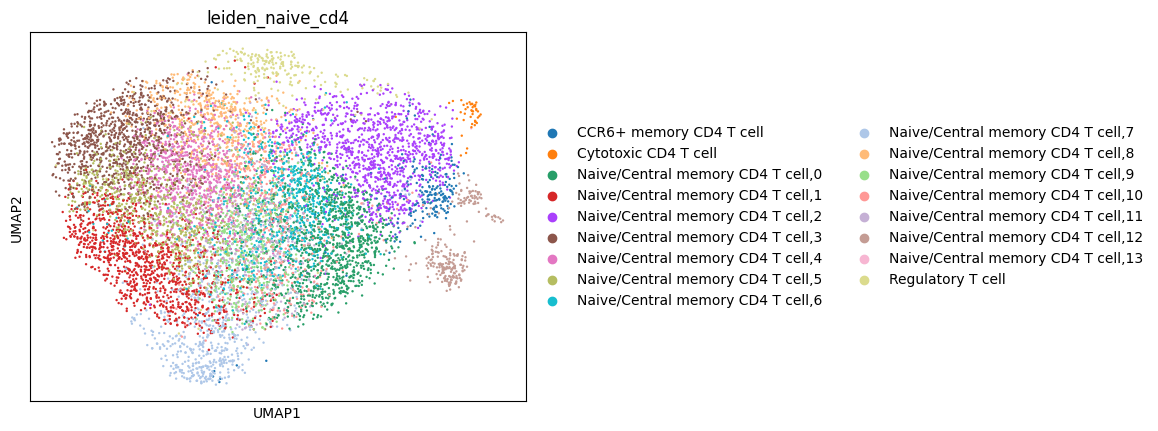

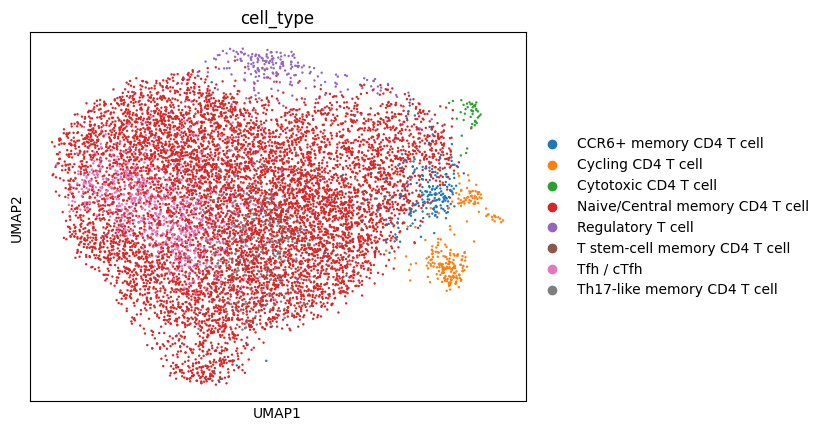

In [12]:
sc.pl.umap(naive_memory_cd4, color=['leiden_naive_cd4'], legend_loc='right margin')
sc.pl.umap(naive_memory_cd4, color=[ 'cell_type'], legend_loc='right margin')


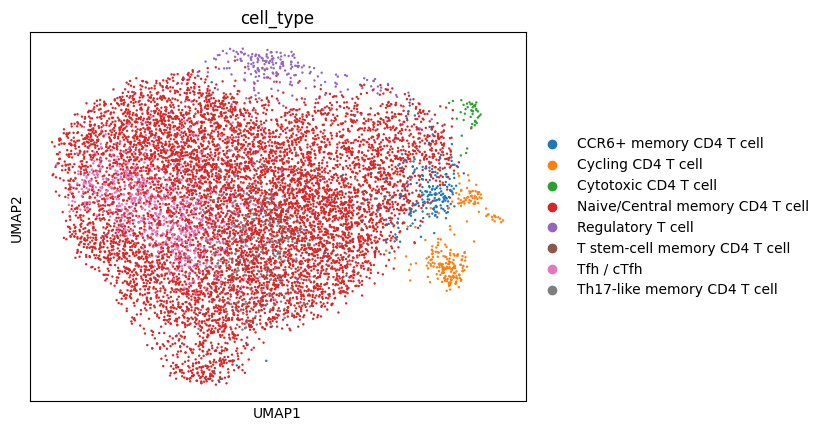

In [13]:
# Update the cell annotation
cd4.obs['cell_type'] = cd4.obs['cell_type'].astype(str)
cd4.obs['cell_type'].update(naive_memory_cd4.obs['cell_type'])
sc.pl.umap(cd4, color='cell_type')

In [15]:
cd4.obs['cell_type'].unique()
cd4.obs['cell_type'].value_counts()

cell_type
Naive/Central memory CD4 T cell    8057
Tfh / cTfh                          806
Th17-like memory CD4 T cell         424
Regulatory T cell                   267
Cycling CD4 T cell                  239
CCR6+ memory CD4 T cell             222
Cytotoxic CD4 T cell                 43
T stem-cell memory CD4 T cell         1
Name: count, dtype: int64

In [14]:
cd4.write_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_cd4_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_cd4_scVI_annot_tfh.h5ad", compression='gzip')
